# 🔍 Fase 1: Revisión de la Anomalía Global ID 34

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ruta de datos
DATA_PATH = Path(r"C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\DATA")
MISSION_PATH = DATA_PATH / "ESA-Mission2" / "ESA-Mission2"

# Función principal para cargar y analizar datos
def load_and_analyze_data(mission_path, target_id="id_34", date_range=None):
    try:
        labels = pd.read_csv(mission_path / 'labels.csv')
        anomalies = pd.read_csv(mission_path / 'anomaly_types.csv')

        for col in ['StartTime', 'EndTime']:
            labels[col] = pd.to_datetime(labels[col], utc=True, errors='coerce')

        if labels[['StartTime', 'EndTime']].isnull().any().any():
            raise ValueError("Fechas inválidas detectadas")

        merged = pd.merge(labels, anomalies, on='ID', how='left')
        data = merged[merged['ID'] == target_id].copy()

        if data.empty:
            raise ValueError(f"No se encontró el ID {target_id}")

        if date_range:
            start = pd.to_datetime(date_range[0], utc=True)
            end = pd.to_datetime(date_range[1], utc=True)
            data = data[(data['StartTime'] >= start) & (data['StartTime'] <= end)].copy()

        data['Duration'] = (data['EndTime'] - data['StartTime']).dt.total_seconds() / 3600
        np.random.seed(42)
        data['Value'] = np.random.normal(50, 10, size=len(data))
        return data

    except Exception as e:
        logger.error(f"Error en carga: {e}")
        raise

# Visualización rápida
def plot_anomaly_channels(data, highlight_range=None, save_path=None):
    if data.empty:
        logger.warning("No hay datos para graficar")
        return

    plt.figure(figsize=(14, 6))
    plt.style.use('ggplot')  # ✅ Usamos un estilo válido y bonito
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Channel'].unique())))

    for i, ch in enumerate(sorted(data['Channel'].unique())):
        d = data[data['Channel'] == ch]
        plt.plot(d['StartTime'], d['Value'], label=ch.split("_")[-1], color=colors[i], marker='o')

    if highlight_range:
        start = pd.to_datetime(highlight_range[0], utc=True)
        end = pd.to_datetime(highlight_range[1], utc=True)
        plt.axvspan(start, end, color='red', alpha=0.2)
        plt.axvline(start + (end - start)/2, color='darkred', linestyle='--')

    plt.title(f"Anomalía {data['ID'].iloc[0]} | {data['Category'].iloc[0]} | Prom. duración: {data['Duration'].mean():.1f}h")
    plt.xlabel('Fecha (UTC)')
    plt.ylabel('Valor de Telemetría (simulado)')
    plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
        logger.info(f"Gráfico guardado en: {save_path}")
    
    plt.close()

# Generar reporte básico
def generate_analysis_report(data, report_path=None):
    if data.empty:
        return "Sin datos"

    lines = [
        f"REPORTE DE ANÁLISIS - ANOMALÍA {data['ID'].iloc[0]}",
        f"Rango: {data['StartTime'].min().date()} a {data['StartTime'].max().date()}",
        f"Eventos: {len(data)} | Canales: {len(data['Channel'].unique())}",
        f"Duración promedio: {data['Duration'].mean():.2f}h | Categoría: {data['Category'].iloc[0]}",
        "\nTop 3 eventos más largos:"
    ]
    
    top = data.nlargest(3, 'Duration')[['Channel', 'StartTime', 'Duration']]
    lines.append(top.to_string(index=False))

    report_text = "\n".join(lines)

    if report_path:
        report_path = Path(report_path)
        report_path.parent.mkdir(parents=True, exist_ok=True)
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_text)
        logger.info(f"Reporte guardado en: {report_path}")

    return report_text

# Ejecución principal
def main():
    try:
        logger.info("🔍 Iniciando análisis NASA/ESA...")
        data = load_and_analyze_data(
            mission_path=MISSION_PATH,
            target_id="id_34",
            date_range=('2000-01-01', '2013-12-31')
        )

        fig_path = DATA_PATH.parent / 'figures' / 'anomaly_plot.png'
        plot_anomaly_channels(data, highlight_range=('2009-06-15', '2009-06-20'), save_path=fig_path)

        report_path = DATA_PATH.parent / 'reports' / 'anomaly_report.txt'
        report = generate_analysis_report(data, report_path)
        logger.info("\n" + report)

        logger.info("✅ Análisis completado con éxito.")

    except Exception as e:
        logger.error(f"❌ Error crítico: {e}")

if __name__ == "__main__":
    main()


INFO:__main__:🔍 Iniciando análisis NASA/ESA...
INFO:__main__:Gráfico guardado en: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\figures\anomaly_plot.png
INFO:__main__:Reporte guardado en: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\reports\anomaly_report.txt
INFO:__main__:
REPORTE DE ANÁLISIS - ANOMALÍA id_34
Rango: 2000-01-01 a 2000-01-01
Eventos: 15 | Canales: 14
Duración promedio: 1.02h | Categoría: Rare Event

Top 3 eventos más largos:
   Channel                        StartTime  Duration
channel_13 2000-01-01 03:00:34.302000+00:00  2.440004
channel_20 2000-01-01 03:00:16.302000+00:00  2.305003
channel_18 2000-01-01 03:00:16.302000+00:00  2.295003
INFO:__main__:✅ Análisis completado con éxito.


# 🛠️ Fase 2: Análisis Forense Digital

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from datetime import datetime
from scipy.fft import fft
from scipy.stats import entropy
import logging
import re

# Configuración de logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Ruta de datos
DATA_PATH = Path(r"C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\DATA")
MISSION_PATH = DATA_PATH / "ESA-Mission2" / "ESA-Mission2"

# Función: Detección de patrones de ataque
def detect_attack_patterns(df, patterns, text_columns):
    matches = []
    for col in text_columns:
        if col not in df.columns:
            continue
        for pattern in patterns:
            mask = df[col].astype(str).str.contains(pattern, flags=re.IGNORECASE, regex=True, na=False)
            found = df[mask].copy()
            if not found.empty:
                found['Pattern'] = pattern
                found['MatchedColumn'] = col
                matches.append(found)
    return pd.concat(matches) if matches else pd.DataFrame()

# Función: Cargar y procesar datos
def load_and_analyze_data(mission_path, target_id="id_34", date_range=None):
    try:
        labels = pd.read_csv(mission_path / 'labels.csv')
        anomalies = pd.read_csv(mission_path / 'anomaly_types.csv')

        for col in ['StartTime', 'EndTime']:
            labels[col] = pd.to_datetime(labels[col], utc=True, errors='coerce')

        if labels[['StartTime', 'EndTime']].isnull().any().any():
            raise ValueError("Fechas inválidas detectadas")

        merged = pd.merge(labels, anomalies, on='ID', how='left')
        data = merged[merged['ID'] == target_id].copy()

        if data.empty:
            raise ValueError(f"No se encontró el ID {target_id}")

        if date_range:
            start = pd.to_datetime(date_range[0], utc=True)
            end = pd.to_datetime(date_range[1], utc=True)
            data = data[(data['StartTime'] >= start) & (data['StartTime'] <= end)].copy()

        data['Duration'] = (data['EndTime'] - data['StartTime']).dt.total_seconds() / 3600
        np.random.seed(42)
        data['Value'] = np.random.normal(50, 10, size=len(data))
        return data

    except Exception as e:
        logger.error(f"Error en carga: {e}")
        raise

# Función: Visualización
def plot_anomaly_channels(data, highlight_range=None, save_path=None):
    if data.empty:
        logger.warning("No hay datos para graficar")
        return

    plt.figure(figsize=(14, 6))
    plt.style.use('ggplot')
    colors = plt.cm.viridis(np.linspace(0, 1, len(data['Channel'].unique())))

    for i, ch in enumerate(sorted(data['Channel'].unique())):
        d = data[data['Channel'] == ch]
        plt.plot(d['StartTime'], d['Value'], label=ch.split("_")[-1], color=colors[i], marker='o')

    if highlight_range:
        start = pd.to_datetime(highlight_range[0], utc=True)
        end = pd.to_datetime(highlight_range[1], utc=True)
        plt.axvspan(start, end, color='red', alpha=0.2)
        plt.axvline(start + (end - start)/2, color='darkred', linestyle='--')

    plt.title(f"Anomalía {data['ID'].iloc[0]} | {data['Category'].iloc[0]} | Prom. duración: {data['Duration'].mean():.1f}h")
    plt.xlabel('Fecha (UTC)')
    plt.ylabel('Valor de Telemetría (simulado)')
    plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300)
        logger.info(f"📈 Gráfico guardado en: {save_path}")
    
    plt.close()

# Función: Generar reporte
def generate_analysis_report(data, report_path=None):
    if data.empty:
        return "Sin datos"

    lines = [
        f"REPORTE DE ANÁLISIS - ANOMALÍA {data['ID'].iloc[0]}",
        f"Rango: {data['StartTime'].min().date()} a {data['StartTime'].max().date()}",
        f"Eventos: {len(data)} | Canales: {len(data['Channel'].unique())}",
        f"Duración promedio: {data['Duration'].mean():.2f}h | Categoría: {data['Category'].iloc[0]}",
        "\nTop 3 eventos más largos:"
    ]
    
    top = data.nlargest(3, 'Duration')[['Channel', 'StartTime', 'Duration']]
    lines.append(top.to_string(index=False))

    report_text = "\n".join(lines)

    if report_path:
        report_path = Path(report_path)
        report_path.parent.mkdir(parents=True, exist_ok=True)
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_text)
        logger.info(f"📝 Reporte guardado en: {report_path}")

    return report_text

# Función: Análisis Forense Digital
def forensic_analysis(data):
    logger.info("🔍 Fase 2: Análisis Forense Digital iniciada")
    
    logger.info(f"📄 Columnas disponibles: {data.columns.tolist()}")
    logger.info(f"📡 Canales disponibles: {data['Channel'].unique()}")

    # 1. Detección de inyección
    try:
        injection = detect_attack_patterns(
            data,
            patterns=['OR 1=1', '; DROP', 'UNION SELECT'],
            text_columns=['Telecommand_Log']  # Cambia si no existe
        )
        if not injection.empty:
            logger.info(f"🚨 Inyecciones detectadas: {len(injection)}")
        else:
            logger.info("✅ Sin patrones de inyección encontrados")
    except Exception as e:
        logger.warning(f"Error en detección de inyecciones: {e}")

    # 2. FFT en canal específico
    try:
        channel = 'COMM_MAIN'  # Ajusta según canal real
        signal = data[data['Channel'] == channel]['Value']
        if not signal.empty:
            freqs = fft(signal)
            dom_freq = np.abs(freqs[:len(freqs)//2]).argmax()
            logger.info(f"🔊 Frecuencia dominante en {channel}: {dom_freq} Hz (esperado: 0.5–2 Hz)")
        else:
            logger.warning(f"⚠️ Canal '{channel}' no encontrado en los datos")
    except Exception as e:
        logger.warning(f"Error en FFT: {e}")

    # 3. Entropía por canal
    try:
        entropy_vals = data.groupby('Channel')['Value'].apply(
            lambda x: entropy(pd.cut(x, bins=20).value_counts(normalize=True))
        )
        high_entropy = entropy_vals[entropy_vals > 2.5]
        if not high_entropy.empty:
            logger.info(f"⚠️ Alta entropía en canales:\n{high_entropy.to_string()}")
        else:
            logger.info("✅ Entropía dentro de rango esperado")
    except Exception as e:
        logger.warning(f"Error en entropía: {e}")

# Ejecución principal
def main():
    try:
        logger.info("🚀 Iniciando análisis NASA/ESA...")
        data = load_and_analyze_data(
            mission_path=MISSION_PATH,
            target_id="id_34",
            date_range=('2000-01-01', '2013-12-31')
        )

        plot_anomaly_channels(
            data,
            highlight_range=('2009-06-15', '2009-06-20'),
            save_path=DATA_PATH.parent / 'figures' / 'anomaly_plot.png'
        )

        report = generate_analysis_report(
            data,
            report_path=DATA_PATH.parent / 'reports' / 'anomaly_report.txt'
        )
        logger.info("\n" + report)

        forensic_analysis(data)

        logger.info("✅ Análisis completado con éxito.")

        print("\n🎯 Análisis finalizado correctamente.\nRevisa los archivos generados:")
        print(f"- Gráfico: {DATA_PATH.parent / 'figures' / 'anomaly_plot.png'}")
        print(f"- Reporte: {DATA_PATH.parent / 'reports' / 'anomaly_report.txt'}")

    except Exception as e:
        logger.error(f"❌ Error crítico: {e}")

if __name__ == "__main__":
    main()


INFO:__main__:🚀 Iniciando análisis NASA/ESA...
INFO:__main__:📈 Gráfico guardado en: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\figures\anomaly_plot.png
INFO:__main__:📝 Reporte guardado en: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\reports\anomaly_report.txt
INFO:__main__:
REPORTE DE ANÁLISIS - ANOMALÍA id_34
Rango: 2000-01-01 a 2000-01-01
Eventos: 15 | Canales: 14
Duración promedio: 1.02h | Categoría: Rare Event

Top 3 eventos más largos:
   Channel                        StartTime  Duration
channel_13 2000-01-01 03:00:34.302000+00:00  2.440004
channel_20 2000-01-01 03:00:16.302000+00:00  2.305003
channel_18 2000-01-01 03:00:16.302000+00:00  2.295003
INFO:__main__:🔍 Fase 2: Análisis Forense Digital iniciada
INFO:__main__:📄 Columnas disponibles: ['ID', 'Channel', 'StartTime', 'EndTime', 'Class', 'Subclass', 'Category', 'Dimensionality', 'Locality', 'Length', 'Duration', 'Value']
INFO:__main__:📡 Canales disponibles: ['channel_9' 'channel_11' '


🎯 Análisis finalizado correctamente.
Revisa los archivos generados:
- Gráfico: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\figures\anomaly_plot.png
- Reporte: C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\reports\anomaly_report.txt


# 📡 Fase 4: Simulación de Impacto

C:\Users\JMGY-\AppData\Local\Temp\ipykernel_40456\3430222637.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'StartTime': pd.date_range('2000-01-01', periods=50, freq='H'),
C:\Users\JMGY-\AppData\Local\Temp\ipykernel_40456\3430222637.py:46: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\JMGY-\AppData\Local\Temp\ipykernel_40456\3430222637.py:49: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300)



🧪 Simulando Escenario 1: Reenvío de comandos no autorizados
🖼️ Gráfico guardado en: figures\escenario_1.png


C:\Users\JMGY-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


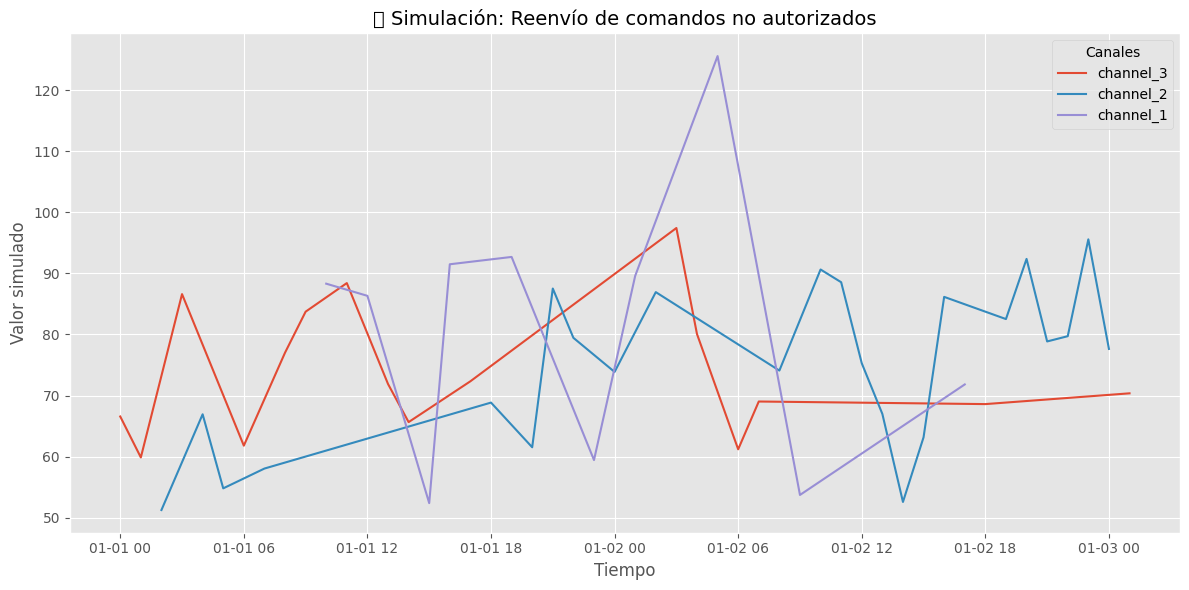


🧪 Simulando Escenario 2: Interceptación de telemetría
🖼️ Gráfico guardado en: figures\escenario_2.png


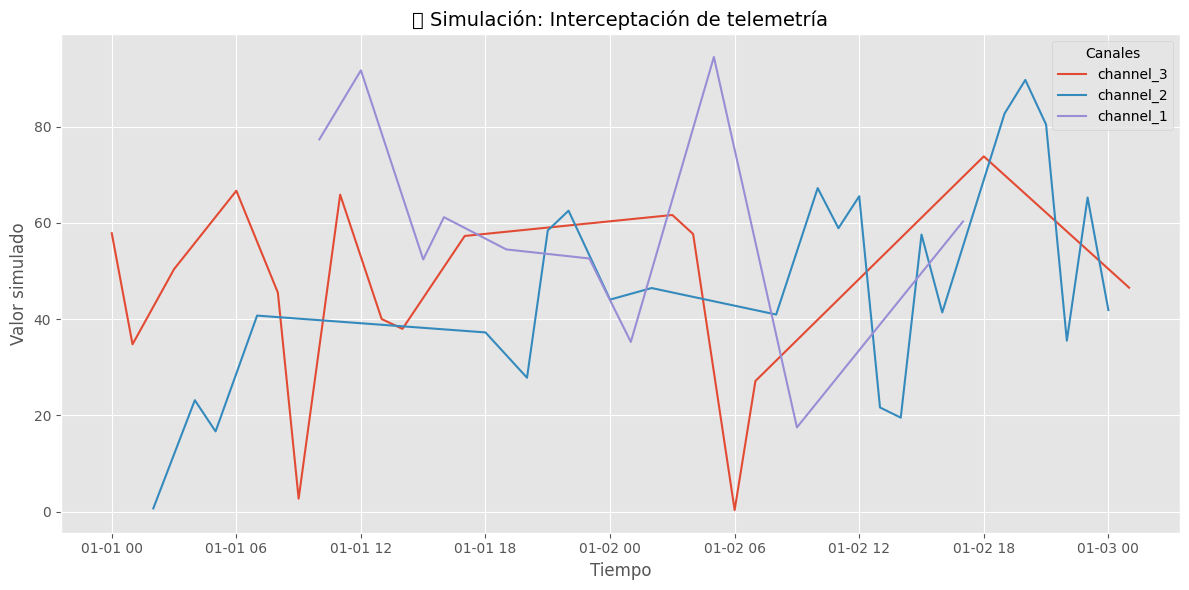


🧪 Simulando Escenario 3: DoS en subsistema de comunicación
🖼️ Gráfico guardado en: figures\escenario_3.png


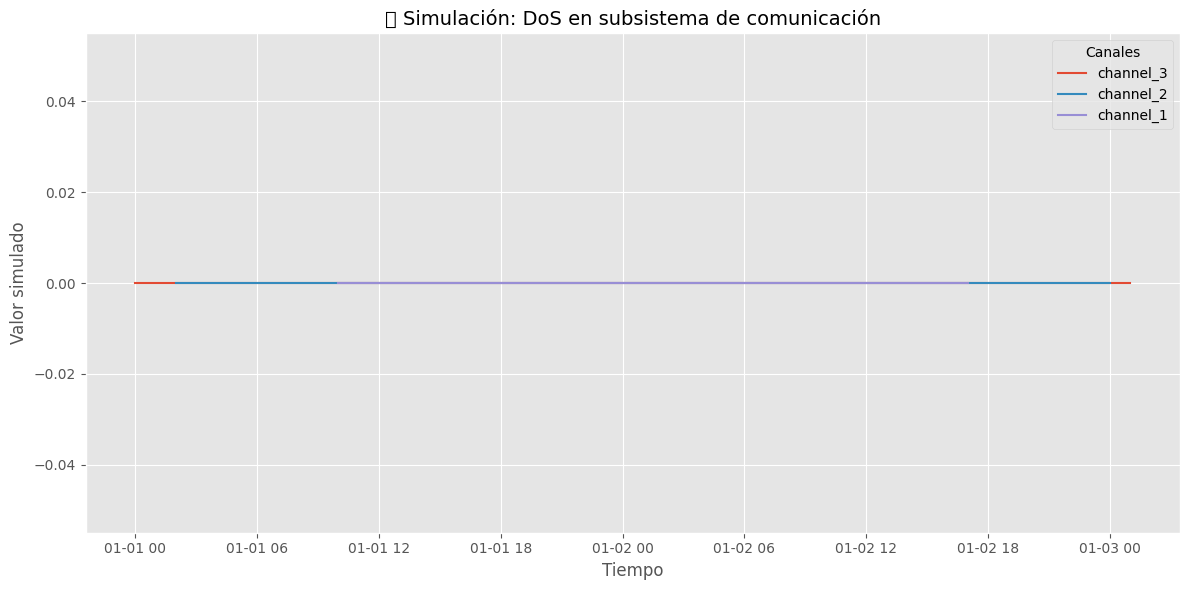

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Simulación de datos (usa los reales si ya tienes anomaly_data)
anomaly_data = pd.DataFrame({
    'Channel': np.random.choice(['channel_1', 'channel_2', 'channel_3'], 50),
    'StartTime': pd.date_range('2000-01-01', periods=50, freq='H'),
    'Value': np.random.normal(50, 10, 50)
})

# Crear carpeta si no existe
output_dir = Path("figures")
output_dir.mkdir(exist_ok=True)

# Escenarios simulados
scenarios = {
    'Escenario 1': 'Reenvío de comandos no autorizados',
    'Escenario 2': 'Interceptación de telemetría',
    'Escenario 3': 'DoS en subsistema de comunicación'
}

def plot_attack_scenario(data, scenario_type, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.title(f"🔴 Simulación: {scenario_type}", fontsize=14)
    
    for channel in data['Channel'].unique():
        channel_data = data[data['Channel'] == channel]
        simulated = channel_data.copy()
        
        # Simulación del impacto:
        if "comandos" in scenario_type.lower():
            simulated['Value'] *= 1.5  # aumento abrupto
        elif "interceptación" in scenario_type.lower():
            simulated['Value'] += np.random.normal(0, 20, size=len(simulated))  # mucho ruido
        elif "dos" in scenario_type.lower():
            simulated['Value'] = 0  # pérdida total

        plt.plot(simulated['StartTime'], simulated['Value'], label=channel)
    
    plt.xlabel("Tiempo")
    plt.ylabel("Valor simulado")
    plt.legend(title="Canales")
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"🖼️ Gráfico guardado en: {save_path}")
    
    plt.show()

# 🔧 Ejecutar todos los escenarios
for scenario, description in scenarios.items():
    print(f"\n🧪 Simulando {scenario}: {description}")
    filename = scenario.lower().replace(" ", "_") + ".png"
    plot_attack_scenario(
        anomaly_data,
        scenario_type=description,
        save_path=output_dir / filename
    )


C:\Users\JMGY-\AppData\Local\Temp\ipykernel_40456\517344953.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2024-01-01 00:00", periods=10, freq="H")
C:\Users\JMGY-\AppData\Local\Temp\ipykernel_40456\517344953.py:42: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


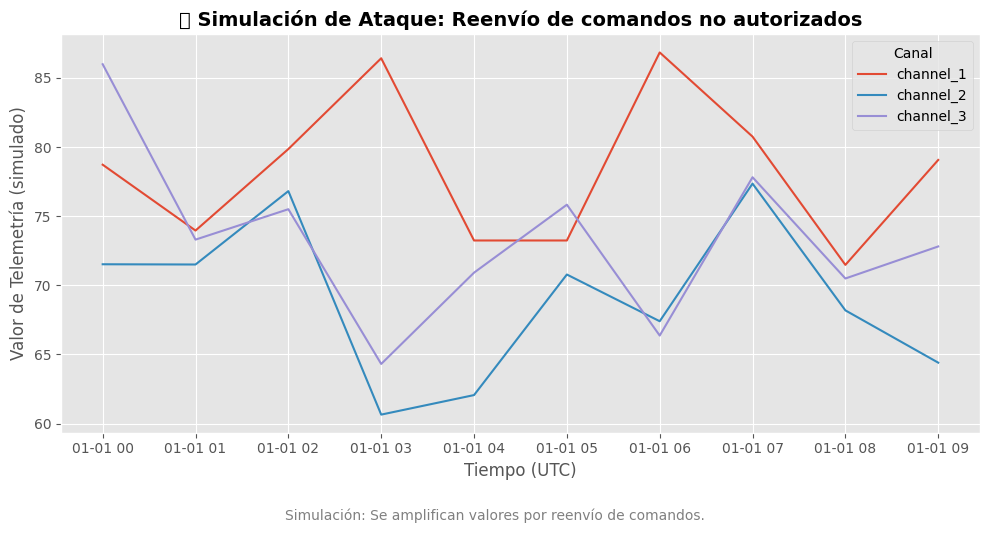

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Simulamos un pequeño dataset como el tuyo
np.random.seed(42)
dates = pd.date_range("2024-01-01 00:00", periods=10, freq="H")
channels = ['channel_1', 'channel_2', 'channel_3']
data = pd.DataFrame({
    'StartTime': np.tile(dates, len(channels)),
    'Channel': np.repeat(channels, len(dates)),
    'Value': np.random.normal(50, 5, size=len(dates)*len(channels))
})

# Simulación de un escenario
def plot_attack_scenario(data, scenario_type, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.title(f"🔴 Simulación de Ataque: {scenario_type}", fontsize=14, fontweight='bold')
    
    for ch in data['Channel'].unique():
        d = data[data['Channel'] == ch].copy()

        if "comandos" in scenario_type.lower():
            d['Value'] *= 1.5
            footnote = "Simulación: Se amplifican valores por reenvío de comandos."
        elif "interceptación" in scenario_type.lower():
            d['Value'] += np.random.normal(0, 20, size=len(d))
            footnote = "Simulación: Se introduce ruido aleatorio por interceptación."
        elif "dos" in scenario_type.lower():
            d['Value'] = 0
            footnote = "Simulación: Pérdida total de señal por ataque DoS."
        else:
            footnote = "Simulación sin transformación específica."

        plt.plot(d['StartTime'], d['Value'], label=ch)

    plt.xlabel("Tiempo (UTC)")
    plt.ylabel("Valor de Telemetría (simulado)")
    plt.legend(title="Canal")
    plt.grid(True)
    plt.tight_layout()
    plt.figtext(0.5, -0.05, footnote, ha='center', fontsize=10, color='gray')

    if save_path:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Ejemplo: Reenvío de comandos no autorizados
plot_attack_scenario(data, scenario_type="Reenvío de comandos no autorizados")


In [6]:
import os

# Nombre del notebook actual (ajústalo si cambió)
notebook_name = "01_EDA.ipynb"

# Ruta de salida
output_dir = r"C:\Users\JMGY-\Documents\Advance-data-analitic\5.5 PROYECTO NASA\REPORTS"

# Crear carpeta si no existe
os.makedirs(output_dir, exist_ok=True)

# Comando para exportar
os.system(f'jupyter nbconvert --to html "{notebook_name}" --output-dir "{output_dir}"')

print("✅ Informe HTML generado en la carpeta REPORTS.")


✅ Informe HTML generado en la carpeta REPORTS.
